In [76]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [77]:
# Don't change the ranomd seed or n
np.random.seed(0)
n = 250
smart_factor = np.random.normal(0, 15, n)
smart_factor_norm = smart_factor / np.max(smart_factor)
iq = 100 + smart_factor
iq = iq.astype(int)
education = np.round(14 + np.random.randint(-4, 2, n) + smart_factor_norm * 5).astype(int)
female = np.random.randint(0, 2, n).astype(bool)
age = 30 + np.random.randint(-10, 20, n)
income_level = np.random.choice(['low', 'medium', 'high'], n, p=[0.4, 0.4, 0.2])
criminal_val = -.15 *iq + -2.5*education + -5*female + -15*(income_level == 'high') + -10*(income_level == 'medium') + -10 * (age > 28) + np.random.randint(-20, 20, n)

# take the bottom 10% of the criminal values and label them as criminals
criminals = criminal_val > np.percentile(criminal_val, 90)

# construct a pandas dataframe with the data
df = pd.DataFrame({'iq': iq, 'education': education, 'female': female, 'age': age, 'income_level': income_level, 'criminals': criminals})
df.loc[3, 'criminals'] = True
df.loc[246, 'criminals'] = True
crime_data = df.__deepcopy__()

In [78]:
# Helper function
def num_rows(array):
    """ Returns the number of rows in a given array """
    if array is None:
        return 0
    elif len(array.shape) == 1:
        return 1
    else:
        return array.shape[0]

# Helper function
def class_counts(data):
    """ Returns a dictionary with the number of samples under each class label
        formatted {label : number_of_samples} """
    if len(data.shape) == 1: # If there's only one row
        return {int(data[-1]) : 1}
    counts = {}
    for label in data[:,-1]:
        if label not in counts:
            counts[int(label)] = 0
        counts[int(label)] += 1
    return counts

# Helper function
def info_gain(data, left, right):
    """Return the info gain of a partition of data.
    Parameters:
        data (ndarray): the unsplit data
        left (ndarray): left split of data
        right (ndarray): right split of data
    Returns:
        (float): info gain of the data"""
        
    def gini(data):
        """Return the Gini impurity of given array of data.
        Parameters:
            data (ndarray): data to examine
        Returns:
            (float): Gini impurity of the data"""
        counts = class_counts(data)
        N = num_rows(data)
        impurity = 1
        for lbl in counts:
            prob_of_lbl = counts[lbl] / N
            impurity -= prob_of_lbl**2
        return impurity
        
    p = num_rows(right)/(num_rows(left)+num_rows(right))
    return gini(data) - p*gini(right)-(1-p)*gini(left)


def find_best_split(data, size_random_subset, min_samples_leaf=5, is_numeric=None):
    # Get feature_choice, define refinement, and initialize the best gain and current_bool
    feature_choice = np.random.choice(data.shape[1], size_random_subset, replace=False)
    refinement = 100/np.min([1+np.abs(data.shape[0] -2*min_samples_leaf -2)// min_samples_leaf,40])
    current_bool = None
    current_gain = 0

    # Initialize the best gain and question and loop through the first n-1 columns
    for i in feature_choice:
        screen = data[:,i]

        # if it is numeric, get the unique split values based on the refinement
        if is_numeric[i]:
            split_vals = np.unique(np.percentile(screen, np.arange(refinement, 100, refinement)))

            # Loop through the split values and partition the data
            for value in split_vals:
                bool_splits = (screen >= value) 

                # If the partition is too small, skip it
                if (np.sum(bool_splits) < min_samples_leaf) or (np.sum(~bool_splits) < min_samples_leaf):
                    continue

                # Calculate the info gain and update the best gain and question if necessary
                gain = info_gain(data, data[bool_splits], data[~bool_splits])
                if gain > current_gain:
                    current_gain, current_bool = gain, bool_splits
        
        # If it is not numeric, get the unique values and the size
        else:
            categories = np.unique(screen)
            cat_size = len(categories)

            # If there are only two categories, there is only one possible split
            if cat_size == 2:
                cat_splits = [[0]]

            # If there are more than two categories, there are many different possible splits. Split individually and then choose random splits
            else:
                cat_splits = [i for i in range(cat_size)]
                random_splits = [np.random.choice(categories, size, replace=False) for size in np.arange(2, cat_size-1, 1)]
                if len(random_splits) > 0:
                    cat_splits.append(random_splits)
                
            # Get the unique splits
            for split in cat_splits:
                bool_splits = np.isin(screen, split)

                # If the partition is too small, skip it
                if (np.sum(bool_splits) < min_samples_leaf) or (np.sum(~bool_splits) < min_samples_leaf):
                    continue
            
                # Calculate the info gain and update the best gain and question if necessary
                gain = info_gain(data, data[bool_splits], data[~bool_splits])
                if gain > current_gain:
                    current_gain, current_bool = gain, bool_splits

    # Return the best gain and split
    return current_gain, current_bool

In [79]:
class Leaf:
    """Tree leaf node
    Attribute:
        prediction (dict): Dictionary of labels at the leaf"""
    def __init__(self,data, index):
        # Count up the number of samples of each class label
        self.prediction = class_counts(data)
        self.index = index


class Decision_Node:
    """Tree node with a question
    Attributes:
        question (Question): Question associated with node
        left (Decision_Node or Leaf): child branch
        right (Decision_Node or Leaf): child branch"""
    def __init__(self, left_branch, right_branch, index):
        # Set the question and branches
        self.left = left_branch
        self.right = right_branch
        self.index = index


class DecisionTree:
    """
    A decision tree class that can be used for classification.
    Attributes:
        data (numpy array): data to use for the tree
        features (list): list of feature names
        min_samples_leaf (int): minimum number of samples in a leaf
        max_depth (int): maximum depth of the tree
        is_numeric (numpy array - boolean): boolean array indicating whether each feature is numeric or not
        size_random_subset (int): number of features to use for each split
        y (numpy array): target variable
        X (numpy array): data without the target variable
    """

    def __init__(self, data, features = None, min_samples_leaf=5, max_depth=4, is_numeric = None, size_random_subset=None):
        """
        Initialize the decision tree
        Inputs:
            data (numpy array): data to use for the tree
            features (list): list of feature names
            min_samples_leaf (int): minimum number of samples in a leaf
            max_depth (int): maximum depth of the tree
            is_numeric (numpy array - boolean): boolean array indicating whether each feature is numeric or not
            size_random_subset (int): number of features to use for each split
        """
        # Initialize the different attributes of the tree
        self.data = data
        self.features = features
        self.min_samples_leaf = min_samples_leaf
        self.max_depth = max_depth
        self.is_numeric = is_numeric
        self.size_random_subset = size_random_subset
        self.graph_weights = np.zeros(2**(max_depth+1) - 1)
        self.test_weights = self.graph_weights.copy()
        
    # Prolem 4
    def build_tree(self, data, current_depth=0, current_index=0):
        """Build a classification tree using the classes Decision_Node and Leaf
        Parameters:
            data (ndarray)
            min_samples_leaf (int): minimum allowed number of samples per leaf
            max_depth (int): maximum allowed depth
            current_depth (int): depth counter
            random_subset (bool): whether or not to train on a random subset of features
        Returns:
            Decision_Node (or Leaf)"""
        # Update the tree structure with its weight strength
        self.graph_weights[current_index] = len(data)

        # If the number of rows is less than the minimum samples per leaf, return a leaf
        if data.shape[0] < 2*self.min_samples_leaf:
            return Leaf(data, current_index)
        
        # Find the best question to ask and return a leaf if there is no gain or past max depth
        gain, bool_split = find_best_split(data, self.size_random_subset, self.min_samples_leaf, self.is_numeric)
        if gain == 0 or current_depth >= self.max_depth:
            return Leaf(data, current_index)
        
        # Partition the data and build the left and right branches
        left, right = data[bool_split], data[~bool_split]
        left_branch = self.build_tree(left, current_depth+1, current_index*2+1)
        right_branch = self.build_tree(right, current_depth+1, current_index*2+2)

        # Return a Decision_Node with the best question and branches
        return Decision_Node(left_branch, right_branch, current_index)
    

    def fit(self):
        """ Fit the decision tree """
        # choose the number of features to use
        if self.size_random_subset is None:
            self.size_random_subset = int(np.sqrt(self.data.shape[1]))

        # Build the tree
        self.tree = self.build_tree(self.data)
    

class AdapativeRandomForest:
    """
    A random forest class that can be used for classification.
    Attributes:
        data (numpy array): data to use for the tree
        features (list): list of feature names
        min_samples_leaf (int): minimum number of samples in a leaf
        max_depth (int): maximum depth of the tree
        is_numeric (numpy array - boolean): boolean array indicating whether each feature is numeric or not
        size_random_subset (int): number of features to use for each split
        y_index (int): index of the column of the target variable
    """
    def __init__(self,dataframe, n_trees = 10, target_index = None, min_samples_leaf=5, max_depth=4, features = None, is_numeric = None, category_codes = {}, size_rand_subset = None):
        """
        Initialize the random forest
        Inputs:
            dataframe (pandas dataframe or numpy array): data to use for the forest
            target_index (int): index of the column of the target variable
            min_samples_leaf (int): minimum number of samples in a leaf
            max_depth (int): maximum depth of the tree
            features (list): list of feature names
            is_numeric (numpy array - boolean): boolean array indicating whether each feature is numeric or not
            category_codes (dict): dictionary of the category codes for each non numeric feature
            size_random_subset (int): number of features to use for each split
        """
        # reorder the columns of the dataframe so that the target_index is the last column
        if target_index is not None:
            cols = list(dataframe.columns)
            cols.append(cols.pop(target_index))
            dataframe = dataframe[cols]

        # If the data is a dataframe, do some preprocessing, make a deep copy, and save the data
        if isinstance(dataframe, pd.DataFrame):
            self.data = None
            self.category_codes = {}
            df = dataframe.__deepcopy__()
            self.features = df.columns

            # Get the numeric columns and save the boolean mask
            numeric_cols = df.select_dtypes(include=['number']).columns
            self.is_numeric = df.columns.isin(numeric_cols)

            # Loop through non numeric columns and convert them to numeric while saving the category codes
            for col in self.features[~self.is_numeric]:
                self.category_codes[col] = dict(enumerate(df[col].astype('category').cat.categories))
                df[col] = df[col].astype('category').cat.codes

            # Save the data
            self.data = df.values

        # If the data is already a numpy array, just save it
        elif isinstance(dataframe, np.ndarray):
            self.data = dataframe
            self.category_codes = category_codes
            self.is_numeric = is_numeric
            self.features = features

        # If the data is not a dataframe or numpy array, raise an error
        else:
            raise ValueError('Data must be a pandas dataframe or numpy array')
        
        # Initialize the rest of the forest attributes
        self.min_samples_leaf = min_samples_leaf
        self.max_depth = max_depth
        self.size_rand_subset = size_rand_subset
        self.n_trees = n_trees
        self.all_train_weights = np.zeros((self.n_trees, 2**(self.max_depth+1) - 1))
        self.tree_strengths = np.zeros(self.n_trees)

    def access_tree(self):
        """ Access the decision tree class """
        return DecisionTree(self.data, self.features, self.min_samples_leaf, self.max_depth, self.is_numeric, self.size_rand_subset)
        
    def fit(self, test_size = .33):
        """ Fit the random forest """
        # Initialize the list of trees
        self.trees = []
        #self.oob_data = []

        # Loop through the number of trees and fit each tree to bootstrapped data
        for i in range(self.n_trees):
            # boot strap our data
            n_samples = len(self.data)
            indices = np.random.randint(0, n_samples, size=n_samples)
            boot_data = self.data[indices]

            # get the out of bag data
            # oob_indices = np.setdiff1d(np.arange(n_samples), indices, assume_unique=True)
            # oob_data = self.data[oob_indices]
            # self.oob_data.append(oob_data)

            # Build the tree and fit it
            tree = DecisionTree(boot_data, self.features, self.min_samples_leaf, self.max_depth, self.is_numeric, self.size_rand_subset)
            tree.fit()

            # Save the tree and the normalized weights
            self.trees.append(tree)
            train_weights = tree.graph_weights
            self.all_train_weights[i] = train_weights / train_weights[0]


########### FIX ME: make it update test graph weights
# Problem 5
def predict_instance(sample, my_tree):
    """Predict the label for a sample given a pre-made decision tree
    Parameters:
        sample (ndarray): a single sample
        my_tree (Decision_Node or Leaf): a decision tree
    Returns:
        Label to be assigned to new sample"""
    # If the tree is a leaf, return the max prediction
    if isinstance(my_tree, Leaf):
        predictions = my_tree.prediction
        return max(predictions, key=predictions.get)
    
    # If the tree is a node, ask the question and recurse
    if my_tree.question.match(sample): ###################### FIX ME: Need to modify the decision tree so that it can ask questions on training data
        return predict_instance(sample, my_tree.left)
    else:
        return predict_instance(sample, my_tree.right)



# Problem 6
def predict_forest(sample, forest):
    """Predict the label for a new sample, given a random forest
    Parameters:
        sample (ndarray): a single sample
        forest (list): a list of decision trees
    Returns:
        Label to be assigned to new sample"""
    # Get the predictions of each tree and return the max
    predictions = [predict_instance(sample, tree) for tree in forest]
    return np.max(predictions)

In [80]:
tester = AdapativeRandomForest(crime_data, n_trees=100)
tester.fit()
cool_weights = tester.all_train_weights.copy()
print(cool_weights)

# check duplicate rows in the cool_weights
print(np.unique(cool_weights, axis=0).shape)


# try baby digits dataset in sklearn


[[1.    0.904 0.096 ... 0.    0.    0.   ]
 [1.    0.796 0.204 ... 0.04  0.02  0.036]
 [1.    0.828 0.172 ... 0.    0.    0.   ]
 ...
 [1.    0.784 0.216 ... 0.    0.    0.   ]
 [1.    0.884 0.116 ... 0.    0.    0.   ]
 [1.    0.908 0.092 ... 0.    0.    0.   ]]
(83, 31)


In [81]:
display(np.linalg.norm(np.array([1,2]) - np.array([2,1]))/np.sqrt(2))
display(np.linalg.norm(np.array([1,2,1,1,1]) - np.array([2,1,1,1,1]))/np.sqrt(5))


1.0

0.6324555320336759

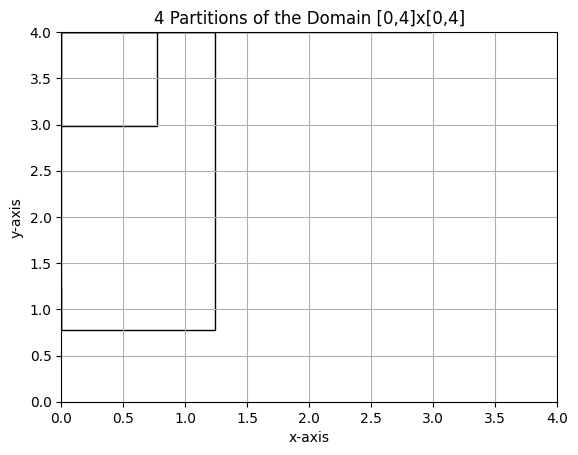

In [90]:
import numpy as np
import matplotlib.pyplot as plt

def recursive_partition(x_range, y_range, depth=0, max_depth=3):
    # Base case: if max depth is reached, return the current partition
    if depth == max_depth:
        return [(x_range, y_range)]

    # Choose to split along x-axis or y-axis randomly
    split_axis = np.random.choice(['x', 'y'])

    # Choose a random split point within the current range
    if split_axis == 'x':
        split_point = np.random.uniform(x_range[0], x_range[1])
        left_partition = recursive_partition((x_range[0], split_point), y_range, depth + 1, max_depth)
        right_partition = recursive_partition((split_point, x_range[1]), y_range, depth + 1, max_depth)
        return left_partition + right_partition
    else:
        split_point = np.random.uniform(y_range[0], y_range[1])
        bottom_partition = recursive_partition(x_range, (y_range[0], split_point), depth + 1, max_depth)
        top_partition = recursive_partition(x_range, (split_point, y_range[1]), depth + 1, max_depth)
        return bottom_partition + top_partition

def plot_partitions(partitions):
    fig, ax = plt.subplots()
    for (x1, y1), (x2, y2) in partitions:
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor='black', facecolor='none')
        ax.add_patch(rect)

    plt.xlim(0, 4)
    plt.ylim(0, 4)
    plt.title(f"{len(partitions)} Partitions of the Domain [0,4]x[0,4]")
    plt.xlabel('x-axis')
    plt.ylabel('y-axis')
    plt.grid(True)
    plt.show()

np.random.seed(37)
# Determine the number of partitions (between 2 to 6 levels deep)
max_depth = np.random.randint(2, 5)

# Generate and plot partitions
partitions = recursive_partition((0, 4), (0, 4), max_depth=max_depth)
plot_partitions(partitions)


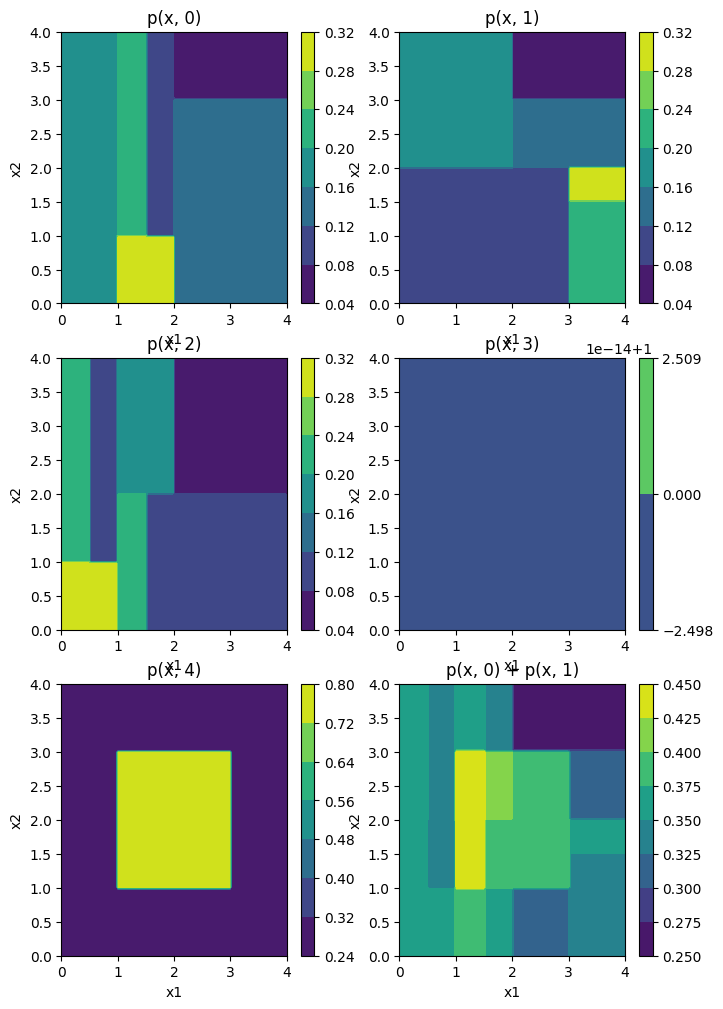

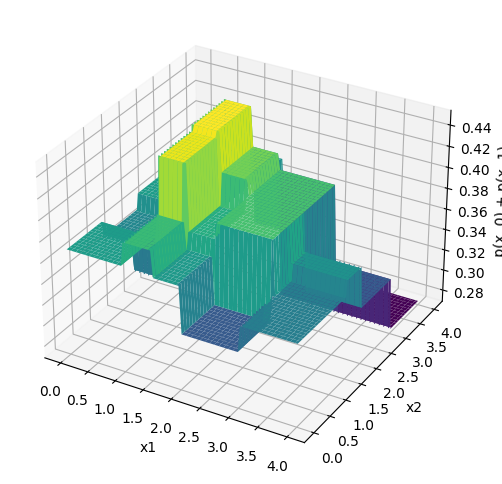

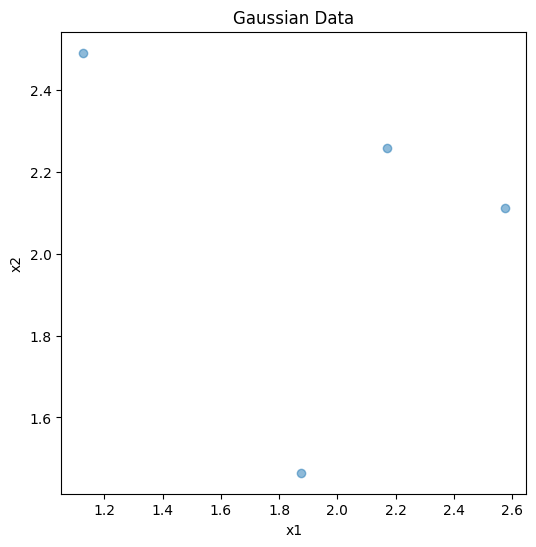

Optimized Weights: [0.00000000e+00 1.39104198e-16 0.00000000e+00 1.00000000e+00
 2.53269627e-16]


In [133]:
import numpy as np
from scipy.optimize import minimize

def objective_function(w, p, x):
    N = len(x)
    l = len(w)
    total_sum = 0
    for i in range(N):
        inner_sum = sum(w[k] * p(x[i], k) for k in range(l))
        total_sum += np.log(inner_sum)
    return -total_sum / N

def constraint(w):
    return sum(w) - 1

# Example p function (modify this as per your step function specifics)
def p(x, k):
    if k == 0:
        if x[0] < 1:
            return .175
        elif x[0] < 2:
            if x[1] < 1:
                return .3
            if x[0] < 1.5:
                return .225
            else:
                return .1
        else:
            if x[1] < 3:
                return .15
            else:
                return .05
    elif k == 1:
        if x[1] < 2:
            if x[0] < 3:
                return .1
            elif x[1] < 1.5:
                return .225
            else:
                return .3
        elif x[0] < 2:
            return .175
        else:
            if x[1] < 3:
                return .15
            else:
                return .05
    elif k == 2:
        if x[0] < 1:
            if x[1] < 1:
                return .3
            elif x[0] < .5:
                return .225
            else:
                return .1
        elif x[1] < 2:
            if x[0] < 1.5:
                return .225
            else:
                return .1
        else:
            if x[0] < 2:
                return .175
            else:
                return .05
    elif k ==3:
        return 1
    elif k == 4:
        if 1 < x[0] < 3 and 1 < x[1] < 3:
            return .75
        else:
            return .25
        
    else:
        raise ValueError("k must be 0 or 1")
    
# make a grid of points to span the domain of [0, 4]x[0, 4]
x1 = np.linspace(0, 4, 100)
x2 = np.linspace(0, 4, 100)
x1, x2 = np.meshgrid(x1, x2)
x_data = np.array([x1, x2]).reshape(2, -1).T

plt.figure(figsize=(8, 12))
for i in range(5):
    plt.subplot(3, 2, i+1)
    plt.contourf(x1, x2, np.array([p(x, i) for x in x_data]).reshape(100, 100))
    plt.title(f"p(x, {i})")
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.colorbar()

w1 = .30 * 1
w2 = .2 * 1
w3 = .25 * 1
w4 = .1 * 1
# Plot the combined probability
plt.subplot(3, 2, 6)
combined =np.array([w1*p(x, 0) + w2*p(x, 1)+ w2*p(x, 2)+ w2*p(x, 3) + (1-w1 - w2 -w3 -w4)*p(x,4) for x in x_data]).reshape(100, 100)
plt.contourf(x1, x2,combined)
plt.title(f"p(x, 0) + p(x, 1)")
plt.xlabel('x1')
plt.ylabel('x2')
plt.colorbar()
plt.show()

# do a 3d plot of combined
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x1, x2, combined, cmap='viridis')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('p(x, 0) + p(x, 1)')
plt.show()


# generate a gaussian dataset centered at 2, 2 with a standard deviation of .5
np.random.seed(100)
N = 4
x1 = np.random.normal(2, .5, N)
x2 = np.random.normal(2, .5, N)
x_data = np.array([x1, x2]).T

# Plot the data
plt.figure(figsize=(6, 6))
plt.scatter(x1, x2, alpha=.5)
plt.title("Gaussian Data")
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

# Initial guess and bounds
l = 5  # Number of w components
w0 = np.ones(l) / l
bounds = [(0, 1) for _ in range(l)]

# Constraint setup
con = {'type': 'eq', 'fun': constraint}

# Optimization
result = minimize(objective_function, w0, args=(p, x_data), bounds=bounds, constraints=con, method='SLSQP')

if result.success:
    optimized_weights = result.x
    print("Optimized Weights:", optimized_weights)
else:
    print("Optimization failed:", result.message)


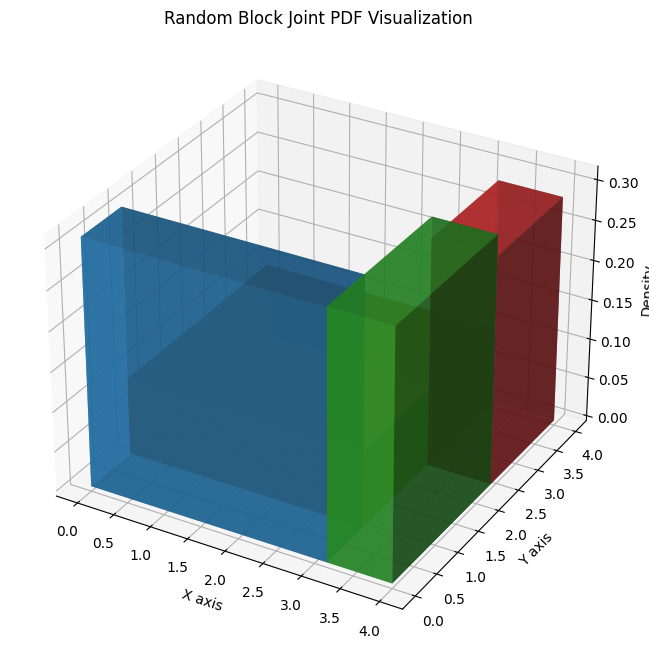

In [146]:
import numpy as np

def generate_random_pdf(splits, x_range, y_range, depth=0, max_depth=3):
    if depth == max_depth or len(splits) >= max_splits:
        # Assign a random density to this block, normalized by the area of the block
        density = np.random.random()
        area = (x_range[1] - x_range[0]) * (y_range[1] - y_range[0])
        return [(x_range, y_range, density / area)]

    # Randomly choose to split along x-axis or y-axis
    split_axis = np.random.choice(['x', 'y'])

    # Choose a random split point within the current range
    if split_axis == 'x':
        split_point = np.random.uniform(x_range[0], x_range[1])
        left_splits = generate_random_pdf(splits, (x_range[0], split_point), y_range, depth + 1, max_depth)
        right_splits = generate_random_pdf(splits, (split_point, x_range[1]), y_range, depth + 1, max_depth)
        return left_splits + right_splits
    else:
        split_point = np.random.uniform(y_range[0], y_range[1])
        bottom_splits = generate_random_pdf(splits, x_range, (y_range[0], split_point), depth + 1, max_depth)
        top_splits = generate_random_pdf(splits, x_range, (split_point, y_range[1]), depth + 1, max_depth)
        return bottom_splits + top_splits

# Example Usage
max_splits = 6  # Maximum number of splits
pdf_blocks = generate_random_pdf([], (0, 4), (0, 4), max_depth=np.random.randint(2, max_splits+1))

# Normalize densities so that their sum equals 1
total_density = sum([block[2] for block in pdf_blocks])
pdf_blocks_normalized = [(x_range, y_range, density/total_density) for x_range, y_range, density in pdf_blocks]

import numpy as np

def generate_random_pdf(splits, x_range, y_range, depth=0, max_depth=3):
    if depth == max_depth or len(splits) >= max_splits:
        # Assign a random density to this block, normalized by the area of the block
        density = np.random.random()
        area = (x_range[1] - x_range[0]) * (y_range[1] - y_range[0])
        return [(x_range, y_range, density / area)]

    # Randomly choose to split along x-axis or y-axis
    split_axis = np.random.choice(['x', 'y'])

    # Choose a random split point within the current range
    if split_axis == 'x':
        split_point = np.random.uniform(x_range[0], x_range[1])
        left_splits = generate_random_pdf(splits, (x_range[0], split_point), y_range, depth + 1, max_depth)
        right_splits = generate_random_pdf(splits, (split_point, x_range[1]), y_range, depth + 1, max_depth)
        return left_splits + right_splits
    else:
        split_point = np.random.uniform(y_range[0], y_range[1])
        bottom_splits = generate_random_pdf(splits, x_range, (y_range[0], split_point), depth + 1, max_depth)
        top_splits = generate_random_pdf(splits, x_range, (split_point, y_range[1]), depth + 1, max_depth)
        return bottom_splits + top_splits

# Example Usage
max_splits = 6  # Maximum number of splits
pdf_blocks = generate_random_pdf([], (0, 4), (0, 4), max_depth=np.random.randint(2, max_splits+1))

# Normalize densities so that their sum equals 1
total_density = sum([block[2] for block in pdf_blocks])
pdf_blocks_normalized = [(x_range, y_range, density/total_density) for x_range, y_range, density in pdf_blocks]

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming pdf_blocks_normalized is the output from the previous function
pdf_blocks_normalized = generate_random_pdf([], (0, 4), (0, 4), max_depth=np.random.randint(2, 6))

# Normalize densities
total_density = sum([block[2] for block in pdf_blocks_normalized])
pdf_blocks_normalized = [(x_range, y_range, density/total_density) for x_range, y_range, density in pdf_blocks_normalized]

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot each block as a bar in 3D
for (x_range, y_range, density) in pdf_blocks_normalized:
    x = x_range[0]
    y = y_range[0]
    z = 0
    dx = x_range[1] - x_range[0]
    dy = y_range[1] - y_range[0]
    dz = density
    ax.bar3d(x, y, z, dx, dy, dz, cmap = 'viridis', alpha=0.7)

# Set labels and title
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Density')
ax.set_title('Random Block Joint PDF Visualization')

plt.show()


### Lab Code Reference

In [ ]:

# Problem 1
class Question:
    """Questions to use in construction and display of Decision Trees.
    Attributes:
        column (int): which column of the data this question asks
        value (int/float): value the question asks about
        features (str): name of the feature asked about
    Methods:
        match: returns boolean of if a given sample answered T/F"""

    def __init__(self, column, value, feature_names):
        self.column = column
        self.value = value
        self.features = feature_names[self.column]

    def match(self, sample):
        """Returns T/F depending on how the sample answers the question
        Parameters:
            sample ((n,), ndarray): New sample to classify
        Returns:
            (bool): How the sample compares to the question"""
        # Return True for all samples satisfying the inequality
        return sample[:,self.column] >= self.value
    

def partition(data, question):
    """Splits the data into left (true) and right (false)
    Parameters:
        data ((m,n), ndarray): data to partition
        question (Question): question to split on
    Returns:
        left ((j,n), ndarray): Portion of the data matching the question
        right ((m-j, n), ndarray): Portion of the data NOT matching the question
    """
    # Get the boolean array of which samples match the question and return the split
    left = question.match(data)
    return data[left], data[~left]


# Prolem 4
def build_tree(data, feature_names, min_samples_leaf=5, max_depth=4, current_depth=0, random_subset=False):
    """Build a classification tree using the classes Decision_Node and Leaf
    Parameters:
        data (ndarray)
        feature_names(list or array)
        min_samples_leaf (int): minimum allowed number of samples per leaf
        max_depth (int): maximum allowed depth
        current_depth (int): depth counter
        random_subset (bool): whether or not to train on a random subset of features
    Returns:
        Decision_Node (or Leaf)"""
    # If the number of rows is less than the minimum samples per leaf, return a leaf
    if data.shape[0] < 2*min_samples_leaf:
        return Leaf(data)
    
    # Find the best question to ask and return a leaf if there is no gain or past max depth
    gain, best_q = find_best_split(data, feature_names, min_samples_leaf, random_subset)
    if gain == 0 or current_depth >= max_depth:
        return Leaf(data)
    
    # Partition the data and build the left and right branches
    left, right = partition(data, best_q)
    left_branch = build_tree(left, feature_names, min_samples_leaf, max_depth, current_depth+1, random_subset)
    right_branch = build_tree(right, feature_names, min_samples_leaf, max_depth, current_depth+1, random_subset)

    # Return a Decision_Node with the best question and branches
    return Decision_Node(best_q, left_branch, right_branch)





def generate_forest(data, feature_names, num_trees=10, min_samples_leaf=5, max_depth=4, random_subset=True):
    """Generate a random forest
    Parameters:
        data (ndarray)
        feature_names(list or array)
        num_trees (int): number of trees in the forest
        min_samples_leaf (int): minimum allowed number of samples per leaf
        max_depth (int): maximum allowed depth
        random_subset (bool): whether or not to train on a random subset of features
    Returns:
        (list): list of decision trees"""
    # Initialize the forest
    forest = []

    # Loop through the number of trees and append a tree to the forest
    for i in range(num_trees):
        np.random.shuffle(data)
        tree = build_tree(data, feature_names, min_samples_leaf, max_depth, 0, random_subset)
        forest.append(tree)

    # Return the forest
    return forest

###################################



def analyze_tree(dataset,my_tree):
    """Test how accurately a tree classifies a dataset
    Parameters:
        dataset (ndarray): Labeled data with the labels in the last column
        tree (Decision_Node or Leaf): a decision tree
    Returns:
        (float): Proportion of dataset classified correctly"""
    # Initialize number of correct predictions
    correct = 0

    # loop through each sample and get the sample and row
    for row in dataset:
        sample = row[:-1]
        label = row[-1]

        # Get the prediction and update the number of correct predictions
        prediction = predict_tree(sample[np.newaxis,:], my_tree)
        if prediction == label:
            correct += 1

    # Return the proportion of correct predictions
    return correct/dataset.shape[0]



def analyze_forest(dataset,forest):
    """Test how accurately a forest classifies a dataset
    Parameters:
        dataset (ndarray): Labeled data with the labels in the last column
        forest (list): list of decision trees
    Returns:
        (float): Proportion of dataset classified correctly"""
    # Initialize number of correct predictions
    correct = 0

    # loop through each sample and get the sample and row
    for row in dataset:
        sample = row[:-1]
        label = row[-1]

        # Get the prediction and update the number of correct predictions
        prediction = predict_forest(sample[np.newaxis,:], forest)
        if prediction == label:
            correct += 1

    # Return the proportion of correct predictions
    return correct/dataset.shape[0]